# Homework 1

## Data processing

In [3]:
# Import needed packages

import numpy as np
import pandas as pd
import nltk
import re
#nltk.download()

In [32]:
# Read data set
data = pd.read_table("speech_data_extend.txt")
print(data.shape)
data.head()

(23155, 3)


,president,speech,year
0,Washington,Fellow-Citizens of the Senate and House of Rep...,1790
1,Washington,I embrace with great satisfaction the opportun...,1790
2,Washington,In resuming your consultations for the general...,1790
3,Washington,Among the many interesting objects which will ...,1790
4,Washington,"A free people ought not only to be armed, but ...",1790


In [3]:
# Remove non-alphabetic characters and tokenize
regex = re.compile('[^a-z]')
docs_list = [doc.lower() for doc in list(data.loc[:,'speech'])]
clean_docs = [nltk.word_tokenize(regex.sub(' ', ''.join(doc))) for doc in docs_list]

In [4]:
#Tokenizing and non-alphabetic character removal done
print(clean_docs[:4])

[['fellow', 'citizens', 'of', 'the', 'senate', 'and', 'house', 'of', 'representatives'], ['i', 'embrace', 'with', 'great', 'satisfaction', 'the', 'opportunity', 'which', 'now', 'presents', 'itself', 'of', 'congratulating', 'you', 'on', 'the', 'present', 'favorable', 'prospects', 'of', 'our', 'public', 'affairs', 'the', 'recent', 'accession', 'of', 'the', 'important', 'state', 'of', 'north', 'carolina', 'to', 'the', 'constitution', 'of', 'the', 'united', 'states', 'of', 'which', 'official', 'information', 'has', 'been', 'received', 'the', 'rising', 'credit', 'and', 'respectability', 'of', 'our', 'country', 'the', 'general', 'and', 'increasing', 'good', 'will', 'toward', 'the', 'government', 'of', 'the', 'union', 'and', 'the', 'concord', 'peace', 'and', 'plenty', 'with', 'which', 'we', 'are', 'blessed', 'are', 'circumstances', 'auspicious', 'in', 'an', 'eminent', 'degree', 'to', 'our', 'national', 'prosperity'], ['in', 'resuming', 'your', 'consultations', 'for', 'the', 'general', 'good',

## Exercise 1

In [5]:
# Remove stop words

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stemmer = nltk.stem.porter.PorterStemmer()
clean_docs_stops = []
for doc in clean_docs:
    doc_wo_stops = [stemmer.stem(word) for word in doc if not word in stop_words]
    clean_docs_stops.append(doc_wo_stops)
print(clean_docs_stops[:2])

[['fellow', 'citizen', 'senat', 'hous', 'repres'], ['embrac', 'great', 'satisfact', 'opportun', 'present', 'congratul', 'present', 'favor', 'prospect', 'public', 'affair', 'recent', 'access', 'import', 'state', 'north', 'carolina', 'constitut', 'unit', 'state', 'offici', 'inform', 'receiv', 'rise', 'credit', 'respect', 'countri', 'gener', 'increas', 'good', 'toward', 'govern', 'union', 'concord', 'peac', 'plenti', 'bless', 'circumst', 'auspici', 'emin', 'degre', 'nation', 'prosper']]


In [6]:
# Get all unique stems/terms
unique = set(word for doc in clean_docs_stops for word in doc)

In [30]:
wordcount_by_doc = [dict.fromkeys(list(unique),0) for i in range(len(clean_docs_stops))]
for index,doc in enumerate(clean_docs_stops):
    for word in doc:
        if word in unique:
            wordcount_by_doc[index][word] = wordcount_by_doc[index][word] + 1

In [31]:
for word,count in wordcount_by_doc[0].items():
    if count!=0 :
        print(word,count)

hous 1
fellow 1
senat 1
repres 1
citizen 1


In [32]:
dt_matrix = pd.DataFrame(wordcount_by_doc)

In [33]:
test = dt_matrix.head()
print(test.shape[0])
print(test.shape[1])
test.iloc[0,0]

5
13550


0

In [34]:
# Get corpus level tf-idf scores of each term

# calculate tf_v

tf_v = 1 + np.log(dt_matrix.sum(axis = 0))

# calculate df_v - find number of non-zero rows for each column

df_v = dt_matrix.astype(bool).sum(axis=0)

idf_v = np.log(dt_matrix.shape[0]/df_v)

# calculate tf-idf

tf_idf_v = tf_v * idf_v

In [35]:
tf_idf_v.sort_values(ascending=False).head()

wool       35.215236
cabl       35.124009
circuit    34.474063
acr        34.403554
texa       34.232973
dtype: float64

In [36]:
def get_tf(x):
    tf = 0
    if (x!=0):
        tf = 1 + np.log(x)
    return(tf)

In [37]:
# calculate the tf_dv matrix

tf_dv = dt_matrix.applymap(get_tf)

# multiply each row of tfdv with idf_v

func = lambda x : np.asarray(x) * np.asarray(idf_v)
tf_idf_dv = tf_dv.apply(func, axis = 1)

In [38]:
# Save dt_matrix and tf-idf to avoid computation later
dt_matrix.to_pickle('dtmatrix.pkl')
tf_idf_v.to_pickle('tfidf_v.pkl')
tf_idf_dv.to_pickle('tfidf_dv.pkl')

## Exercise 2

In [4]:
dt_matrix = pd.read_pickle('dtmatrix.pkl')
tf_idf_v = pd.read_pickle('tfidf_v.pkl')
tf_idf_dv = pd.read_pickle('tfidf_dv.pkl')

In [8]:
# Read dictionary, stem and remove duplicates
myd = pd.read_csv('dict.txt',sep='\t',header=None)
myd.columns = ['word', 'score']
stemmer = nltk.stem.porter.PorterStemmer()
myd['word'] = myd['word'].apply(stemmer.stem)
myd = myd.drop_duplicates()
myd.head()

,word,score
0,abandon,-2
3,abduct,-2
6,abhor,-3
8,abhorr,-3
10,abil,2


In [9]:
# get terms which are in our dictionary
words_in_dic = [word for word in unique if word in set(myd['word'])]
# get s_d = sum of tf-idf*word_score for all documents
tf_idf_dv_select = pd.DataFrame(tf_idf_dv[words_in_dic])
for i in range(tf_idf_dv_select.shape[1]):
    tf_idf_dv_select.iloc[:,i] *= myd.loc[myd['word'] == tf_idf_dv_select.columns[i], 'score'].values[0]

In [10]:
# Sum all the rows of the matrix to get scores for each document
tfidf_wt_results = pd.DataFrame(tf_idf_dv_select.sum(axis=1, numeric_only=True), columns = ['score'])
tfidf_wt_results['meta_president'] = data['president']
tfidf_wt_results['meta_year'] = data['year']
tfidf_wt_results.head()

,score,meta_president,meta_year
0,0.000000,Washington,1790
1,91.595616,Washington,1790
2,82.338856,Washington,1790
3,10.161844,Washington,1790
4,13.174980,Washington,1790


In [11]:
# Repeat the same thing for document term matrix

dt_matrix_select = pd.DataFrame(dt_matrix[words_in_dic])
for i in range(dt_matrix_select.shape[1]):
    wdscore = myd.loc[myd['word'] == dt_matrix_select.columns[i], 'score'].values[0]
    dt_matrix_select.iloc[:,i] *= wdscore

# Sum all the rows of the matrix to get scores for each document
dtmatrix_results = pd.DataFrame(dt_matrix_select.sum(axis=1, numeric_only=True), columns=['score'])
dtmatrix_results['meta_president'] = data['president']
dtmatrix_results['meta_year'] = data['year']
dtmatrix_results.head()

,score,meta_president,meta_year
0,0,Washington,1790
1,29,Washington,1790
2,21,Washington,1790
3,3,Washington,1790
4,4,Washington,1790


In [12]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

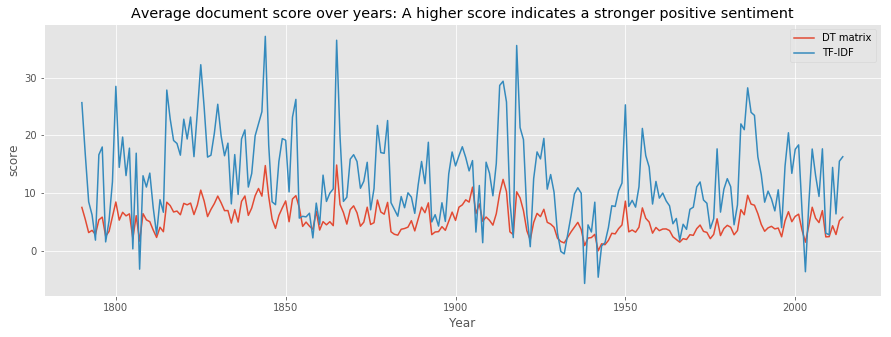

In [13]:
grouped = dtmatrix_results.groupby('meta_year').mean()
plt.figure(figsize=(15,5))
plt.plot(grouped['score'])
grouped = tfidf_wt_results.groupby('meta_year').mean()
plt.plot(grouped['score'])
plt.xlabel('Year')
plt.ylabel('score')
plt.legend(['DT matrix', 'TF-IDF'])
plt.title('Average document score over years: A higher score indicates a stronger positive sentiment')
plt.show()

## Exercise 3

In [71]:
# Compute SVD of tf-idf matrix

A, S, Bt =  np.linalg.svd(tf_idf_dv)

In [ ]:
n_sing = len(S)
newS = S.copy()
newS = newS[:200]
newS = np.append(newS, np.zeros(n_sing-200))
sig_k = np.append(np.diag(newS),np.zeros(shape = [A.shape[0] - n_sing, n_sing]), axis=0)
S_hat = np.matmul(np.matmul(A,sig_k),Bt)

In [52]:
n_sing = A.shape[0]
newS = S.copy()
newS = newS[:200]
newS = np.append(newS, np.zeros(n_sing-200))

In [ ]:
presidents = pd.read_csv("Dem_Rep.csv")
dfshat = pd.DataFrame(S_hat)
dfshat['president'] = data['president']
dfshat = pd.merge(dfshat,presidents, on = 'president')

#### Get cosine similarity for S and $\hat{S}$

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
co_Shat = cosine_similarity(S_hat)

In [49]:
co_S = cosine_similarity(tf_idf_dv)

## Exercise 4

In [29]:
# Initialise variables of the EM algorithm
k = 2 # number of topics
D = dt_matrix.shape[0] # number of documents
V = dt_matrix.shape[1] # number of words
rhos = np.full(k,1/float(k)) # uniform distribution accross topics
betas = np.random.dirichlet(V*[1], k) # probability matrix where the words v appears in topic k
ll_history = [] # array to store all log-likelihood values


tolerance=0.001
max_iter = 50
count = 0
while True:
    # E-step
    ## Log-likelihood
    dt = np.zeros(shape=(D,k))
    for doc in range(D):
        for topic in range(k):
            dt[doc,topic] = np.log(rhos[topic]) + (dt_matrix.values[doc]*np.log(betas[topic])).sum()
    Z_hat = dt - np.max(dt,1)[:,np.newaxis]
    ll = np.log(np.exp(Z_hat).sum(1)).sum()+dt.max(1).sum()

    ### normalize the Zs
    probs = np.exp(dt)/np.exp(dt).sum(1)[:,np.newaxis]
    ll_history.append(ll)

    # M-step
    rhos = probs.sum(0)/D
    betas_temp = np.dot(probs.T, dt_matrix.values)
    betas = betas_temp/betas_temp.sum(1)[:,np.newaxis]

    if (count > 1):
        if (ll-ll_history[-2])<tolerance:
            break
        if (count>max_iter):
            break
    count+=1

/home/lohia/cml/cml-venv/lib/python3.5/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in true_divide


Extremely small values are encountered in the E-step which mkae it impossible to calculate the updated values for the $\rho$'s. We are not able to figure out how to circumvent this problem. Probably using a different data structure for a sparse matrix will help.

In [30]:
rhos

array([ nan,  nan])